# 0. 라이브러리 불러오기

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

# 1. 데이터 불러오기


In [ ]:
df0 = pd.read_excel('/content/양주시인구데이터_0130.xlsx')
print(df0.shape)
display(df0.head(5))
display(df0.tail(5))

(102, 2)


,시간,총인구수
0,2015-06-01,210914
1,2015-07-01,211284
2,2015-08-01,211402
3,2015-09-01,211605
4,2015-10-01,211839


,시간,총인구수
97,2023-07-01,268951
98,2023-08-01,270758
99,2023-09-01,272084
100,2023-10-01,273666
101,2023-11-01,275060


In [ ]:
df0.isnull().sum()

시간      0
총인구수    0
dtype: int64

In [ ]:
stock_a = df0.loc[:, ['시간', '총인구수']]
# 인덱스 설정 후 drop
stock_a.index = stock_a.시간
stock_a = stock_a.drop(columns="시간")
stock_a

,총인구수
시간,
2015-06-01,210914
2015-07-01,211284
2015-08-01,211402
2015-09-01,211605
2015-10-01,211839
...,...
2023-07-01,268951
2023-08-01,270758
2023-09-01,272084


앞의 80% 데이터는 train 데이터로, 뒤의 20% 데이터는 test 데이터로 나누기
시계열 데이터는 시간 변수에 따른 자기상관성이 있기 때문에 함부로 shuffle을 통한 분리를 실시할 수 없는 것이 특징입니다.

In [ ]:
train = stock_a['총인구수'][:int(0.8*len(stock_a))]
test = stock_a['총인구수'][int(0.8*len(stock_a)):]

시각화로 확인

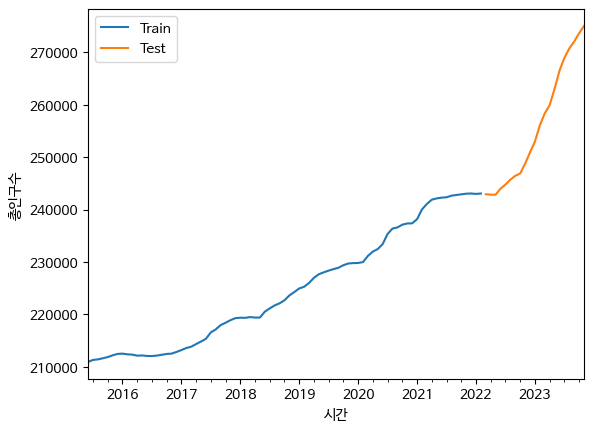

In [ ]:
train.plot(label='Train')
test.plot(label='Test')

plt.xlabel('시간')
plt.ylabel('총인구수')

plt.legend()
plt.show()

추세가 있는 것으로 보이므로 차분을 통해 정상성 데이터로 만들어주어야 할 듯 합니다.

In [ ]:
pip install pmdarima


In [ ]:
import pmdarima as pm

kpss_diffs = pm.arima.ndiffs(train, alpha=0.05, test='kpss', max_d=5)
adf_diffs = pm.arima.ndiffs(train, alpha=0.05, test='adf', max_d=5)
n_diffs = max(kpss_diffs, adf_diffs)

print(f"Optimized 'd' = {n_diffs}")

Optimized 'd' = 2


정상성을 달성하기 위해 필요한 차분의 횟수는 2회

In [ ]:
model2 = pm.auto_arima(train, d=2, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1173.925, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1166.552, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1168.322, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1168.316, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1164.559, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1169.606, Time=0.37 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 1.133 seconds


함수를 사용하여 자동으로 ARIMA 모델을 생성하고 최적의 모델을 찾는 과정을 수행합니다. \
여기서는 train 데이터를 사용하고, d=2로 두 번 차분된 시계열 데이터를 입력으로 넣었습니다. \
시즌성 구성 요소는 고려하지 않도록(seasonal=False) 설정되었습니다.

 AIC 값이 가장낮은 ARIMA(0,2,0) 모델 채택

최적화된 모델 설정

In [ ]:
model2.summary()

In [ ]:
model2.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
test.shape

(21,)

트렌드만을 고려한 예측 진행

In [ ]:
# 예측 -> 리스트로 변환
pred = model2.predict(n_periods=len(test)).to_list()
# 데이터프레임 생성
test_pred = pd.DataFrame({'test':test, 'pred':pred}, index=test.index)
test_pred

,test,pred
시간,,
2022-03-01,242919,243139.0
2022-04-01,242849,243214.0
2022-05-01,242840,243289.0
2022-06-01,243995,243364.0
2022-07-01,244777,243439.0
2022-08-01,245700,243514.0
2022-09-01,246446,243589.0
2022-10-01,246890,243664.0
2022-11-01,248746,243739.0


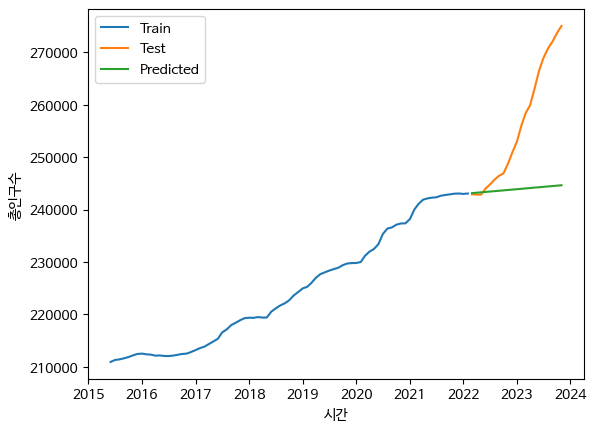

In [ ]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test_pred.pred, label='Predicted')
plt.legend()
plt.xlabel('시간')
plt.ylabel('총인구수')
plt.show()

이번에는 한 지점에 대한 예측을 진행하고 모델을 업데이트 하는 방식으로 예측을 진행 (트렌드 이외에도 변동요인들이 모두 반영 : 추세변동, 계절변동, 순환변동, 불규칙변동)

In [ ]:
# one point forcast 함수 정의, 신뢰구간도 함께 담아보기
def forcast_one_step():
    fc, conf = model2.predict(n_periods=1, return_conf_int=True)
    return fc.tolist()[0], np.asarray(conf).tolist()[0]

# 값들을 담을 빈 리스트를 생성
y_pred = []
pred_upper = []
pred_lower = []

# for문을 통한 예측 및 모델 업데이트를 반복함
for new_ob in test:
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    model2.update(new_ob)

예측 결과를 데이터프레임으로 만들기

In [ ]:
test_pred2 = pd.DataFrame({'test':test, 'pred':y_pred})
y_pred_df = test_pred2['pred']	# Series로 반환
y_pred_df

시간
2022-03-01    243139.0
2022-04-01    242774.0
2022-05-01    242779.0
2022-06-01    242831.0
2022-07-01    245150.0
2022-08-01    245559.0
2022-09-01    246623.0
2022-10-01    247192.0
2022-11-01    247334.0
2022-12-01    250602.0
2023-01-01    253094.0
2023-02-01    255028.0
2023-03-01    259170.0
2023-04-01    260648.0
2023-05-01    261496.0
2023-06-01    266164.0
2023-07-01    269944.0
2023-08-01    271407.0
2023-09-01    272565.0
2023-10-01    273410.0
2023-11-01    275248.0
Name: pred, dtype: float64

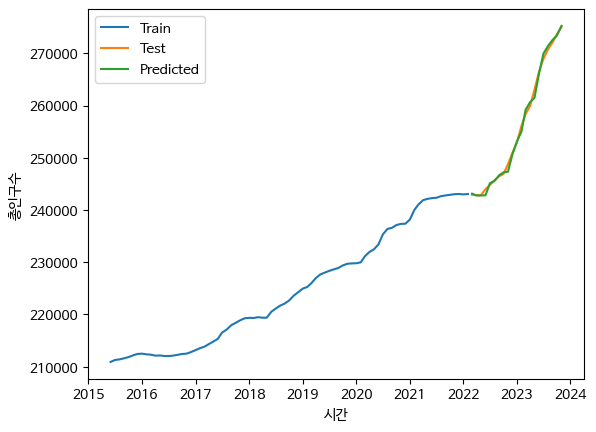

In [ ]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred_df, label='Predicted')
plt.legend()
plt.xlabel('시간')
plt.ylabel('총인구수')
plt.show()

In [ ]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  102
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -756.279
Date:                Thu, 01 Feb 2024   AIC                           1514.558
Time:                        08:04:15   BIC                           1517.163
Sample:                             0   HQIC                          1515.612
                                - 102                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.17e+05   2.24e+04      9.676      0.000    1.73e+05    2.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.40   Jarque-Bera (JB):                25.49
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               6.22   Skew:                             0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# 예측 결과를 저장할 빈 리스트 생성
y_pred = []
pred_upper = []
pred_lower = []

# for문을 통한 예측 및 모델 업데이트 반복
for new_ob in test:
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    model2.update(new_ob)

# 2026년 12월까지의 예측을 포함하여 데이터프레임 생성
예측_월수 = 36  # 원하는 미래 기간에 따라 조절
for _ in range(예측_월수):
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    model2.update(fc)

# 예측 결과를 담은 데이터프레임 생성
test_pred2 = pd.DataFrame({'test': test, 'pred': y_pred[:len(test)]})
y_pred_df = pd.Series(y_pred[len(test):], name='pred', index=pd.date_range(start='2023-12-01', periods=예측_월수, freq='M'))

# 데이터프레임 출력
y_pred_df

2023-12-31    276454.0
2024-01-31    277848.0
2024-02-29    279242.0
2024-03-31    280636.0
2024-04-30    282030.0
2024-05-31    283424.0
2024-06-30    284818.0
2024-07-31    286212.0
2024-08-31    287606.0
2024-09-30    289000.0
2024-10-31    290394.0
2024-11-30    291788.0
2024-12-31    293182.0
2025-01-31    294576.0
2025-02-28    295970.0
2025-03-31    297364.0
2025-04-30    298758.0
2025-05-31    300152.0
2025-06-30    301546.0
2025-07-31    302940.0
2025-08-31    304334.0
2025-09-30    305728.0
2025-10-31    307122.0
2025-11-30    308516.0
2025-12-31    309910.0
2026-01-31    311304.0
2026-02-28    312698.0
2026-03-31    314092.0
2026-04-30    315486.0
2026-05-31    316880.0
2026-06-30    318274.0
2026-07-31    319668.0
2026-08-31    321062.0
2026-09-30    322456.0
2026-10-31    323850.0
2026-11-30    325244.0
Freq: M, Name: pred, dtype: float64

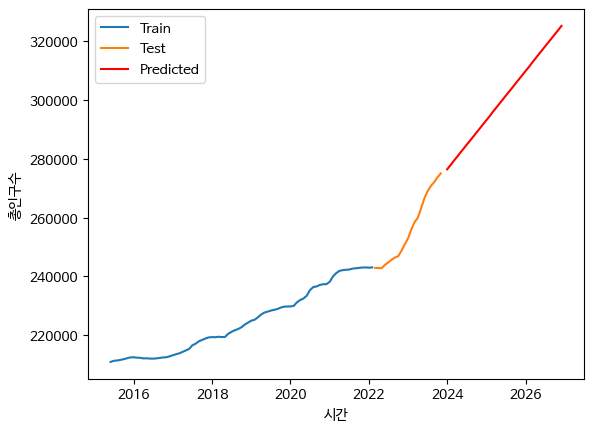

In [ ]:
# 훈련 데이터, 테스트 데이터, 예측값을 플로팅
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred_df, label='Predicted', color='red')  # 예측값을 빨간색으로 설정
plt.legend()
plt.xlabel('시간')
plt.ylabel('총인구수')
plt.show()

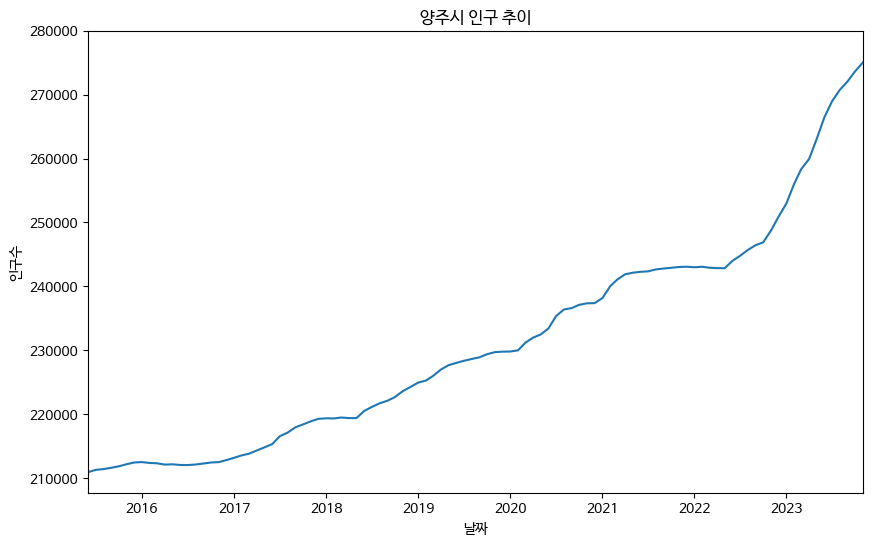

In [ ]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(x='시간', y='총인구수', data=df0)  # 실제 컬럼 이름을 사용해야 합니다.
plt.title('양주시 인구 추이')  # 그래프 제목 설정
plt.xlabel('날짜')  # x축 레이블 설정
plt.ylabel('인구수')  # y축 레이블 설정
plt.grid(False)  # 그리드 비활성화

# x 축 범위 설정 (시작점, 끝점 지정)
plt.xlim(df0['시간'].min(), df0['시간'].max())  # '시간' 컬럼 값의 최소, 최대값으로 범위 설정

# y 축 범위 설정 (최대값 지정)
plt.ylim(plt.ylim()[0], 280000)  # 현재 y 축의 최소값부터 최대값까지 범위 중 최소값은 그대로 유지하고 최대값을 280000으로 설정

# 그래프 표시
plt.show()

In [ ]:
# pmdarima 라이브러리에서 ARIMA 모델을 사용
import pmdarima as pm

# 예측 결과를 저장할 빈 리스트 생성
y_pred = []

# for문을 통한 예측 및 모델 업데이트 반복 (2015-06-01 ~ 2022-02-01)
for new_ob in train:  # train 데이터를 사용하여 모델을 학습
    # pmdarima의 ndiffs 함수를 사용하여 차분 횟수 결정
    kpss_diffs = pm.arima.ndiffs(train, alpha=0.05, test='kpss', max_d=5)
    adf_diffs = pm.arima.ndiffs(train, alpha=0.05, test='adf', max_d=5)
    n_diffs = max(kpss_diffs, adf_diffs)

    # ARIMA 모델 학습 및 예측
    model = pm.ARIMA(order=(1, n_diffs, 1))
    model.fit(train)
    fc = model.predict(1)[0]

    y_pred.append(fc)
    model.update(new_ob)

# 2022-03-01부터 2023-11-01까지의 예측을 포함하여 데이터프레임 생성
예측_월수 = 21  # 2022-03-01부터 2023-11-01까지 21개월
for _ in range(예측_월수):
    # ARIMA 모델을 사용하여 한 단계씩 예측하고 모델 업데이트
    fc = model.predict(1)[0]
    y_pred.append(fc)
    model.update(fc)

# 예측 결과를 담은 데이터프레임 생성
pred_dates = pd.date_range(start='2022-03-01', periods=예측_월수, freq='M')
y_pred_df = pd.DataFrame({'pred': y_pred[len(train):]}, index=pred_dates)

# 데이터프레임 출력
print(y_pred_df)


In [ ]:
# 예측 결과를 저장할 빈 리스트 생성
y_pred = []
pred_upper = []
pred_lower = []

# for문을 통한 예측 및 모델 업데이트 반복 (2015-06-01 ~ 2022-02-01)
for new_ob in train:  # train 데이터를 사용하여 모델을 학습
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    model2.update(new_ob)

# 2022-03-01부터 2023-11-01까지의 예측을 포함하여 데이터프레임 생성
예측_월수 = 21  # 2022-03-01부터 2023-11-01까지 21개월
for _ in range(예측_월수):
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    model2.update(fc)

# 예측 결과를 담은 데이터프레임 생성
pred_dates = pd.date_range(start='2022-03-01', periods=예측_월수, freq='M')
y_pred_df = pd.DataFrame({'pred': y_pred[len(train):]}, index=pred_dates)

# 데이터프레임 출력
print(y_pred_df)

                pred
2022-03-31  243139.0
2022-04-30  243214.0
2022-05-31  243289.0
2022-06-30  243364.0
2022-07-31  243439.0
2022-08-31  243514.0
2022-09-30  243589.0
2022-10-31  243664.0
2022-11-30  243739.0
2022-12-31  243814.0
2023-01-31  243889.0
2023-02-28  243964.0
2023-03-31  244039.0
2023-04-30  244114.0
2023-05-31  244189.0
2023-06-30  244264.0
2023-07-31  244339.0
2023-08-31  244414.0
2023-09-30  244489.0
2023-10-31  244564.0
2023-11-30  244639.0


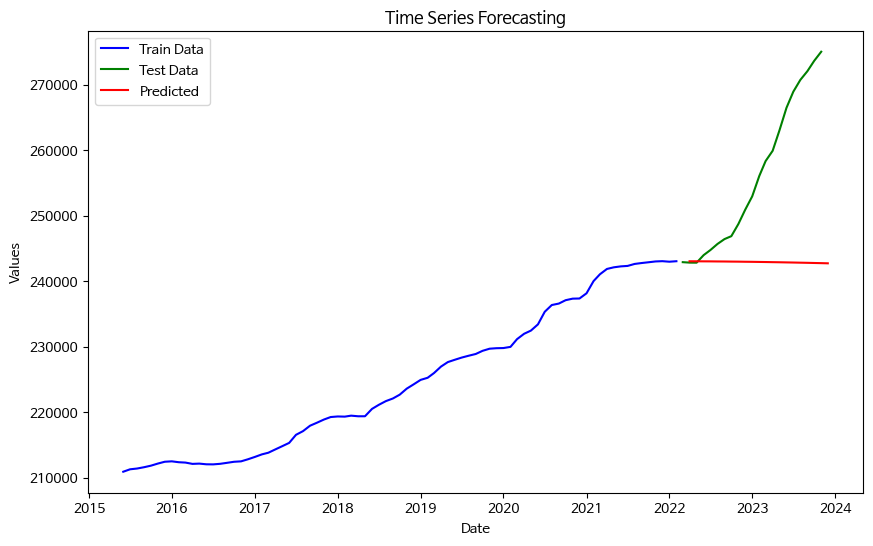

In [ ]:
# 예측 결과를 담은 데이터프레임 생성
pred_dates = pd.date_range(start='2022-03-01', periods=예측_월수, freq='M')
y_pred_df = pd.DataFrame({'pred': y_pred[len(train):]}, index=pred_dates)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(y_pred_df.index, y_pred_df['pred'], label='Predicted', color='red')
plt.title('Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()


참고 ) https://velog.io/@dankj1991/time-series-3-ARIMA
